# Beer, Wine and Data Science

## Data Science Project - EDA, Visualisations and Regressions

<img src="https://data.iowa.gov/api/assets/066AB31D-1B66-4E3E-9B61-AACDBC4024E5" align="right" style="width: 250px;"/>
A key part of being a good Data Scientists is having skills in the areas of statistics, programming as well as business knowledge. Whether it is building data products, prediction engines or doing data analytics, it is essential that the Data Science workflow is geared towards satisfying business objectives. For this project, we draw our dataset from [the Iowa government website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) for liquor sales, and take on the role of a Data Science consultant for the Iowa state tax board. 

In this scenario, the Iowa State legislature is considering changes in the liquor tax rates, and wants a report of current liquor sales by county and projections for the rest of the year. Our objectives are as thus to discover the underlying structure and trends in the data, and to report them to our stakeholders in a clear and concise manner, using the appropriate visualisations.

### Data munging

Let's now load in our data and handy data handling libraries.

In [1]:
import pandas as pd
import numpy as np

# Load the data into a DataFrame
df = pd.read_csv('Iowa_Liquor_sales_sample_10pct.csv')

We have 270955 entries in our dataset! It's not quite big data, but certainly would have been infeasible to handle without programming and our Data Scientist's toolbox. We also see it is quite heterogeneous: we have integers, floats, dates, and differently formatted strings, which will require some handling before it is fit for analysis.

In [2]:
print df.shape
df.head()

(270955, 18)


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


Deciding whether or not to drop data entries is a matter that requires some thought. Is there a pattern to the invalid entries that contain NaNs or other useless data? Are they truly random? What is the proportion of entries being dropped compared to the whole, and will its omission materially affect our analysis? In some cases it may be necessary to impute values, and perhaps even an investigation into the data acquisition methodology and integrity of the ETL (Extract-Transform-Load) pipeline.

Forunately in our case, the missing values make up only a very small percentage of our entire dataset as shown below. The nature of our data is such that a small amount of entries cannot have an outsize impact on the aggregate properties, and thus can be safely dropped. Remember: in a business setting, time is a resource! 

In [3]:
print df.shape
df.dropna(how='any', axis = 0, inplace=True)
print df.shape

(270955, 18)
(269258, 18)


The method `pandas.to_datetime()` here helps us convert the string datatype of our `Date` column in the `datetime64` datatype, thus making it amenable to later analysis.

In [5]:
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
dollar = ['State Bottle Cost','State Bottle Retail','Sale (Dollars)']
for col in dollar:
    df[col].replace("\$","", regex=True, inplace=True)
    df[col] = pd.to_numeric(df[col])
df.head(2)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40


Datatypes are an essential item to note througout the data munging process. Here we show that our previous steps have satisfactorily transformed our features into their appropriate datatypes for further analysis and modelling.

In [6]:
df.dtypes

Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

# Exploratory Data Analysis

Here we perform exploratory statistical analysis and make some plots to visualise the interesting aspects of our dataset.

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

### Time period of dataset

The first thing we establish here is the timeframe of our dataset: from 5th January 2015 to 31st March 2016, spanning 451 days.

In [8]:
print "The first chronological datapoint occurred on:"
print df.ix[df['Date'].idxmin(),'Date']
print "The last chronological datapoints occurred on:"
print df.ix[df['Date'].idxmax(),'Date']
print "Spanning over a period of:"
print df.ix[df['Date'].idxmax(),'Date'] - df.ix[df['Date'].idxmin(),'Date']

The first chronological datapoint occurred on:
2015-01-05 00:00:00
The last chronological datapoints occurred on:
2016-03-31 00:00:00
Spanning over a period of:
451 days 00:00:00


### Correlations

Here we make use of the heatmap as a visual tool to discover the correlations between pairs of features. The scale on the right shows us how to read the chart: the deeper the shade of colour, the stronger the correlation between the corresponding pairs of variables, and vice versa. Positive correlations are marked by red, while negative ones are indicated by blue.

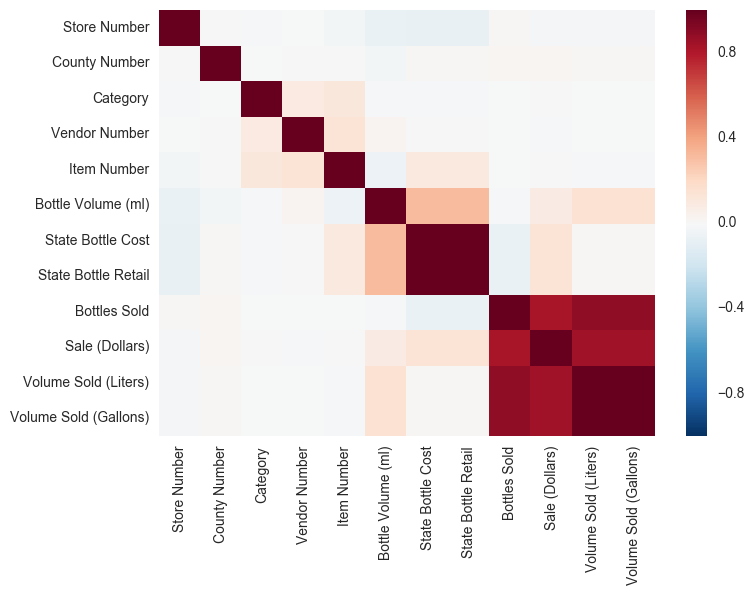

In [9]:
sns.heatmap(df.corr())
plt.show()

In [10]:
numeric = df.loc[:,['State Bottle Cost','State Bottle Retail','Bottles Sold',
                   'Sale (Dollars)','Volume Sold (Liters)','Volume Sold (Gallons)']]

### Pairplot

The `pairplot()` method of the `seaborn` package enables us to quickly visualise the relationships between pairs of variables. Already we are seeing clear linear relationships, however some remain difficult to read. In these cases, scaling and appropriate transformation such as plotting log or log-log graphs may serve to clarify the relationship or lack thereof.

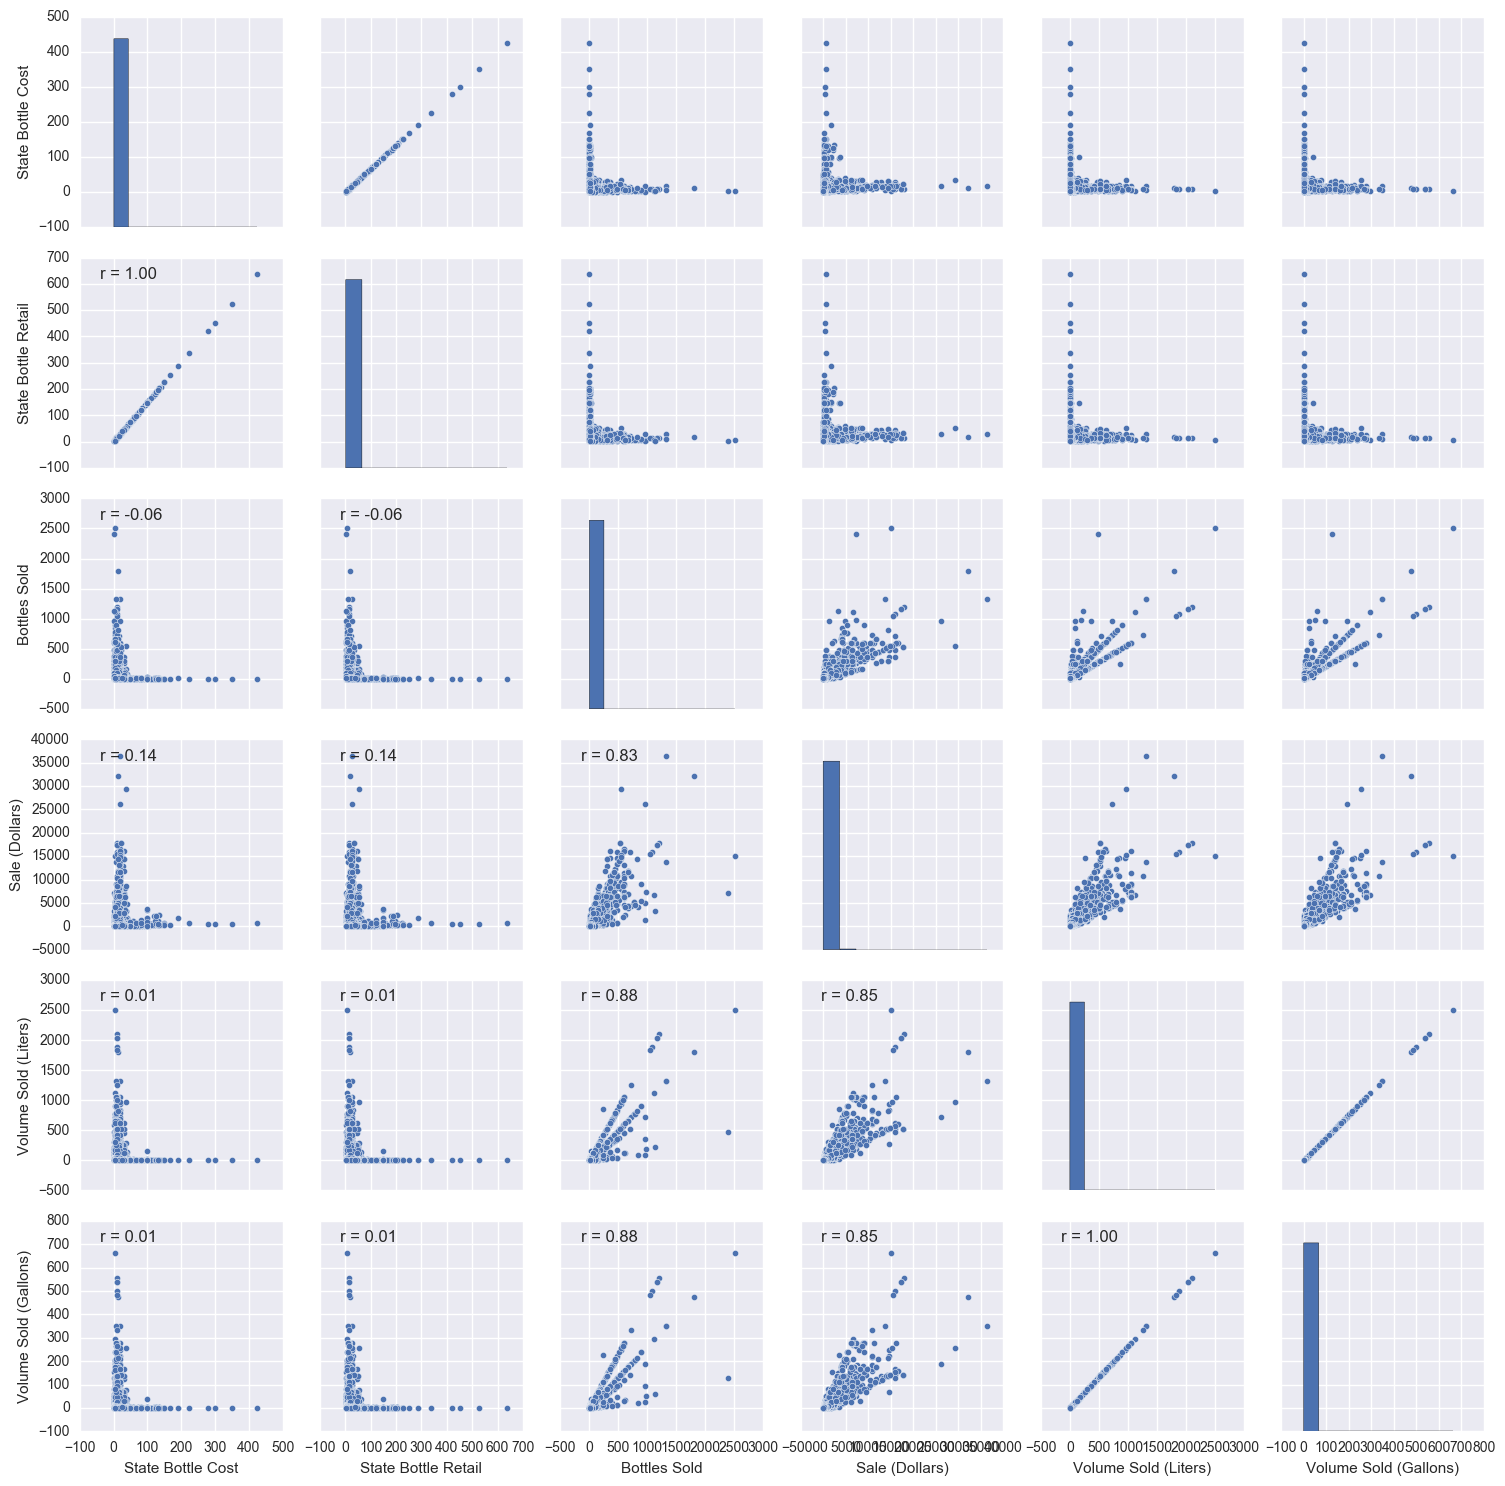

In [11]:
from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.pairplot(data=numeric)
g.map_lower(corrfunc)
plt.show()

Judging by the histograms, the numeric parameters have Pareto-like distributions. They are investigated in further detail at the end of this notebook as an appendix.

### Observations on Correlations

The following parameters are tightly correlated with one another:

- Sales (Dollars)
- Bottles Sold
- Volume Sold (Litres / Gallons)

Which is to be expected. Additionally, the following pair have an almost perfect correlation = 0.99 :

- State Bottle Cost
- State Bottle Retail

Which is again to be expected. 

### Sales over time

We now look at the time series aspect of our data. Can we discover any trends that may be noteworthy to our stakeholders?

In [12]:
time = pd.pivot_table(df, index="Date", values="Sale (Dollars)", aggfunc=np.sum)
print time.head()
print "\nStandard Deviation:", time.std()
print "Skew:", time.skew()
time.describe()

Date
2015-01-05    165133.30
2015-01-06    117254.79
2015-01-07    146504.34
2015-01-08     99617.52
2015-01-12    120179.01
Name: Sale (Dollars), dtype: float64

Standard Deviation: 40963.4796702
Skew: -0.838954397937


count       274.000000
mean     126598.966022
std       40963.479670
min          67.480000
25%      108737.870000
50%      128563.340000
75%      147857.017500
max      266365.400000
Name: Sale (Dollars), dtype: float64

Both the Standard Deviation and Skew tell us vital information about the distribution of our time series data. The negative skew is a curiosity that we will look at promptly by plotting the sales: 

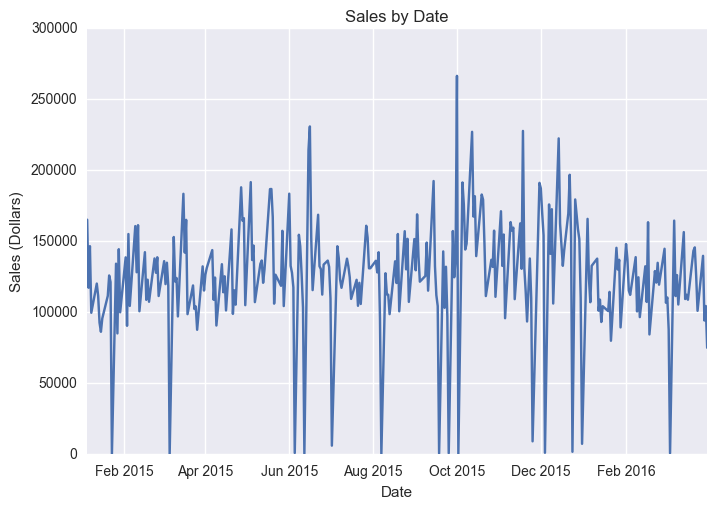

In [13]:
plt.plot(time)
plt.title('Sales by Date')
plt.ylabel('Sales (Dollars)')
plt.xlabel('Date')
plt.show()

### Sales over time

Daily sales of alcohol fluctuated over the 451 day period around a mean of ~\$125k, with the 25% quartile at ~\$100k and 75% quartile at ~\$150k with significant spikes both to the upside and downside, resulting in an overall negative skew towards the downside. There is no visible overall trend in the time series.

### Yearly sales breakdown by store

Segmentation is an extremely useful tool for business - it gives us fine grained detail of what is going on. In the case of a web app, segmentation by geography, age, OS used are just some of the more obvious possible ways to break down customers for better targeting. In our scenario, it would be valuable to know if certain big players are dominating the market, for example.

For sales data, segmentation of time periods by quarters is the de facto way. Let's now further break down our `Date` feature into 4 quarters:

In [14]:
def quarter(x):
    if x<=3:
        return 1
    elif x<=6:
        return 2
    elif x<=9:
        return 3
    else:
        return 4
df["Year"] = df['Date'].apply(lambda x: x.year)
df["Month"] = df['Date'].apply(lambda x: x.month)
df["Quarter"] = df['Month'].apply(lambda x: quarter(x))

Then to have a better organisation of our data, we make use the `pivot_table()` method.

In [15]:
df['Sales_2015']= df.loc[df['Year'] == 2015, 'Sale (Dollars)']
df['Q1_Sales'] = df.loc[df['Quarter'] == 1, 'Sale (Dollars)']
df['Q1_Sales_2015'] = df.loc[df['Year'] == 2015, 'Q1_Sales']
df['Q1_Sales_2016'] = df.loc[df['Year'] == 2016, 'Q1_Sales']
pivoted = pd.pivot_table(df.iloc[:,:], 
                         values = ['Bottles Sold', 
                                   'Sale (Dollars)', 
                                   'State Bottle Cost', 
                                   'State Bottle Retail', 
                                   'Volume Sold (Liters)',
                                   'Sales_2015', 
                                   'Q1_Sales_2015', 
                                   'Q1_Sales_2016'], 
                         index = 'Store Number', 
                         aggfunc=np.sum)

In [16]:
print pivoted.shape
pivoted.dropna(how='any',axis=0,inplace=True)
print pivoted.shape
pivoted.head(3)

(1378, 8)
(1176, 8)


,Bottles Sold,Q1_Sales_2015,Q1_Sales_2016,Sale (Dollars),Sales_2015,State Bottle Cost,State Bottle Retail,Volume Sold (Liters)
Store Number,,,,,,,,
2106,12573,39287.29,30478.75,176517.45,146038.70,6722.95,10092.37,11836.10
2113,830,2833.25,2065.90,11376.12,9310.22,1994.22,2993.26,836.85
2130,9144,24272.57,27856.11,139440.02,111583.91,5083.25,7627.72,8436.27


# Linear Regressions

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [17]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

### Linear regression to predict yearly sales by store

We will perform a linear regression to predict yearly sales using sales figures from the first quarter of 2015 only.

In [18]:
lm = linear_model.LinearRegression(fit_intercept = True)

X = pivoted['Q1_Sales_2015'].reshape(1176,1) # throws errors otherwise
y = pivoted['Sale (Dollars)'].reshape(1176,1)

model = lm.fit(X,y)
y_pred = model.predict(X)

print('Coefficient: '+ str(model.coef_[0][0]))
print('Intercept: ' + str(model.intercept_[0]))
print('MSE: '+ str(mean_squared_error(y_pred, y)))
print('R^2: '+ str(r2_score(y, y_pred)))

Coefficient: 5.4326385255
Intercept: 960.171858243
MSE: 158658997.387
R^2: 0.963583657231


Based on the high $R^2$ score, the model trained on Q1 sales explains ~96% of the variance in Sales in 2015. 

## Data Visualisation

### Training the model

We use scatter plots to show the Predicted vs Actual sales in 2015 for visually assessing the model's accuracy.

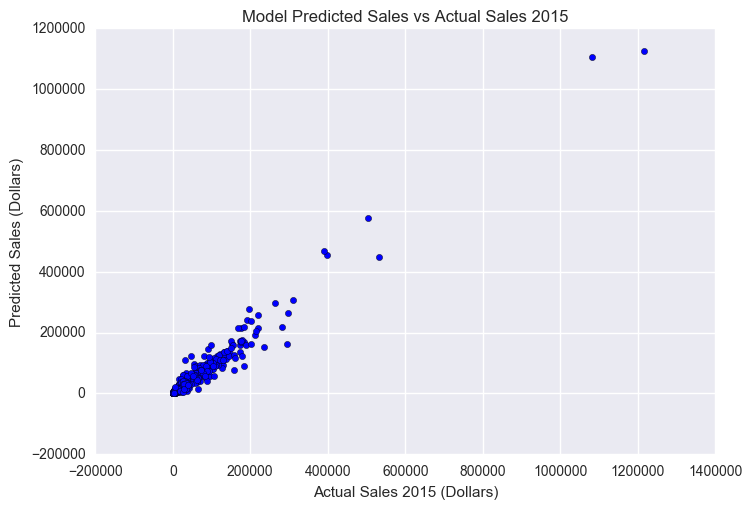

In [19]:
X = pivoted['Q1_Sales_2015'].reshape(1176,1)
y = pd.Series(pivoted['Sale (Dollars)'])

model = lm.fit(X,y)
y_pred = model.predict(X)

plt.scatter(y, y_pred)
plt.title('Model Predicted Sales vs Actual Sales 2015')
plt.xlabel('Actual Sales 2015 (Dollars)')
plt.ylabel('Predicted Sales (Dollars)')
plt.show()

The extreme outlier points make it difficult to visually assess the spread of points. Taking log on both x and y scales gives us:

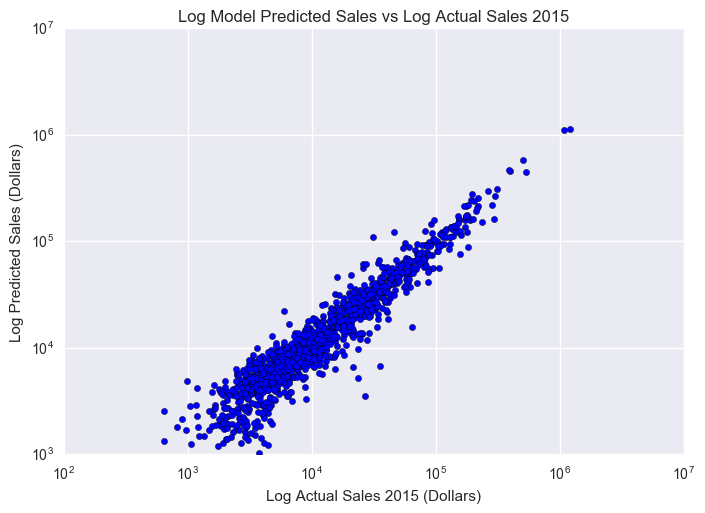

In [20]:
plt.scatter(y, y_pred)
plt.title('Log Model Predicted Sales vs Log Actual Sales 2015')
plt.xlabel('Log Actual Sales 2015 (Dollars)')
plt.ylabel('Log Predicted Sales (Dollars)')
plt.xscale('log')
plt.yscale('log')
plt.show()

This is in line with the high $R^2$ score calculated above.

### 2016 Q1 Sales: _The 'Test' Set_

Having trained the model on 2015 Q1 sales and validated it on 2015 total sales, we will now test its accuracy on 2016 Q1 data.

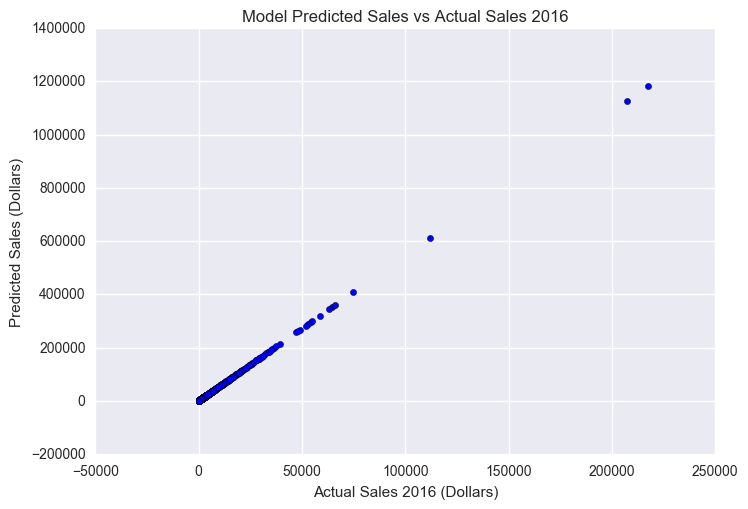

In [21]:
Q1_Sales_2016 = pivoted['Q1_Sales_2016'].reshape(1176,1)

y_pred = model.predict(Q1_Sales_2016)
predicted_sales_2016 = y_pred.sum()

plt.scatter(Q1_Sales_2016, y_pred)
plt.title('Model Predicted Sales vs Actual Sales 2016')
plt.xlabel('Actual Sales 2016 (Dollars)')
plt.ylabel('Predicted Sales (Dollars)')
plt.show()

Once again, the extreme outlier points make it difficult to visually assess the spread of points. Taking log on both x and y scales gives us:

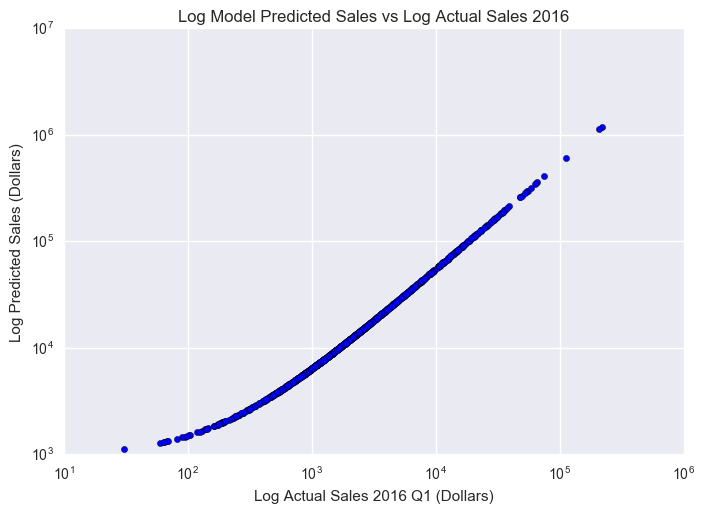

In [22]:
plt.scatter(Q1_Sales_2016, y_pred)
plt.title('Log Model Predicted Sales vs Log Actual Sales 2016')
plt.xlabel('Log Actual Sales 2016 Q1 (Dollars)')
plt.ylabel('Log Predicted Sales (Dollars)')
plt.xscale('log')
plt.yscale('log')
plt.show()

There is a significant deviation between the predicted sales and actual sales in 2016. The model overestimates the amount of sales.

In [41]:
df['Sales_2015'].sum()

28478661.980001435

In [46]:
print Q1_Sales_2016.sum()
print Q1_Sales_2016.sum()*4 # rough estimate

5970882.51
23883530.04


In [47]:
predicted_sales_2016 # significantly higher predicted sales

33566808.460372575

# Results

Based on the high $R^2$ score of the single predictor model of alcohol sales by Q1 sales in 2015, we can say that there is a strong correlation between Q1 sales and total annual sales.

However, the fitted model predicts sales that are significantly higher than is borne out by the actual sales data in Q1 of 2016.

## Additional Observations from EDA

### Drink popularity

This is measured in 3 ways:

- Total number of bottles sold
- Total sales (Dollars)
- Total volume sold

In [25]:
drink_types = pd.pivot_table(df, index=['Category Name'], values = ['Bottles Sold','Sale (Dollars)','Volume Sold (Liters)'], aggfunc=np.sum)
drink_types.head()

,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
Category Name,,,
100 PROOF VODKA,33512,274392.35,34282.76
AMARETTO - IMPORTED,48,2241.60,36.00
AMERICAN ALCOHOL,5769,76614.75,4326.75
AMERICAN AMARETTO,10476,67059.19,9675.55
AMERICAN COCKTAILS,53062,569021.22,82539.12


#### By Bottles Sold

In [26]:
drink_types.sort(['Bottles Sold'], ascending=False, inplace = True)
print drink_types['Bottles Sold'].head(3)
print drink_types['Bottles Sold'].tail(3)

Category Name
VODKA 80 PROOF       516028
CANADIAN WHISKIES    322656
SPICED RUM           177817
Name: Bottles Sold, dtype: int64
Category Name
LOW PROOF VODKA               38
CORN WHISKIES                 27
HIGH PROOF BEER - AMERICAN     2
Name: Bottles Sold, dtype: int64


/Users/matt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


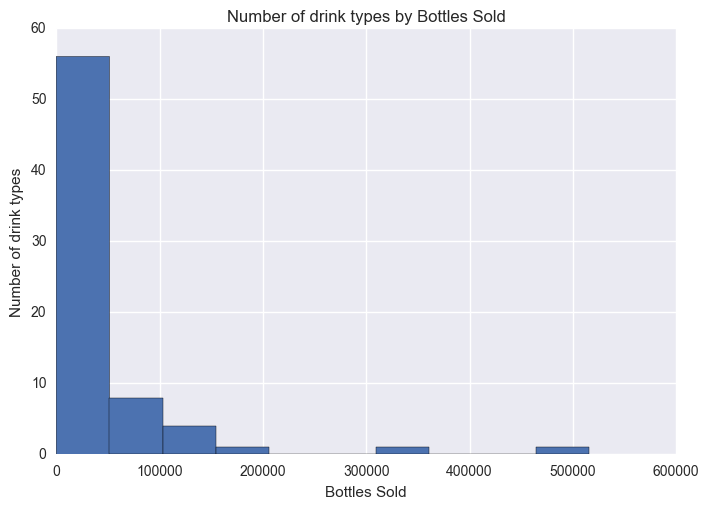

In [27]:
plt.hist(drink_types['Bottles Sold'])
plt.title('Number of drink types by Bottles Sold')
plt.xlabel('Bottles Sold')
plt.ylabel('Number of drink types')
plt.show()

#### By sales in dollars

In [28]:
drink_types.sort(['Sale (Dollars)'], ascending=False, inplace = True)
print drink_types['Sale (Dollars)'].head(3)
print drink_types['Sale (Dollars)'].tail(3)

Category Name
CANADIAN WHISKIES    4388110.83
VODKA 80 PROOF       4197713.86
SPICED RUM           2720973.84
Name: Sale (Dollars), dtype: float64
Category Name
CORN WHISKIES                 876.86
LOW PROOF VODKA               598.12
HIGH PROOF BEER - AMERICAN    285.52
Name: Sale (Dollars), dtype: float64


/Users/matt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


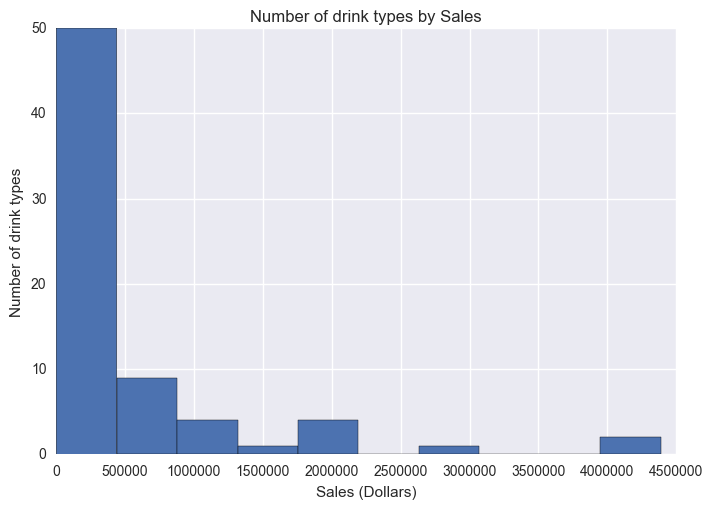

In [29]:
plt.hist(drink_types['Sale (Dollars)'])
plt.title('Number of drink types by Sales')
plt.xlabel('Sales (Dollars)')
plt.ylabel('Number of drink types')
plt.show()

#### By volume sold in litres

In [30]:
drink_types.sort(['Volume Sold (Liters)'], ascending=False, inplace = True)
print drink_types['Volume Sold (Liters)'].head(3)
print drink_types['Volume Sold (Liters)'].tail(3)

Category Name
VODKA 80 PROOF       494899.96
CANADIAN WHISKIES    336083.57
SPICED RUM           176751.72
Name: Volume Sold (Liters), dtype: float64
Category Name
LOW PROOF VODKA               28.50
CORN WHISKIES                 20.25
HIGH PROOF BEER - AMERICAN     1.50
Name: Volume Sold (Liters), dtype: float64


/Users/matt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


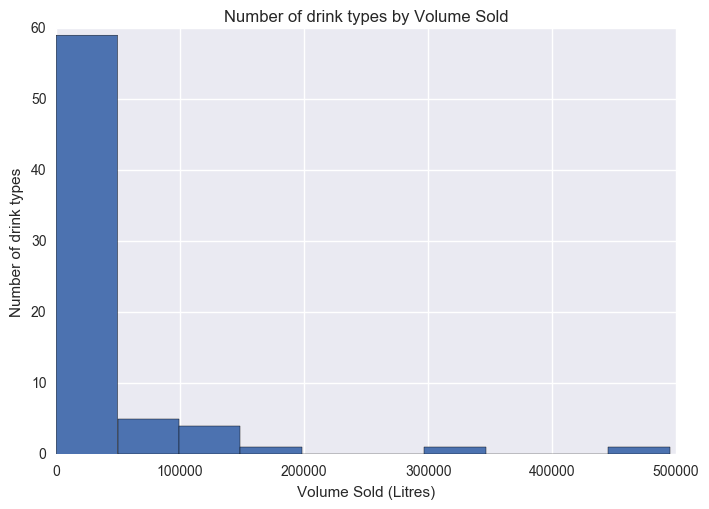

In [31]:
plt.hist(drink_types['Volume Sold (Liters)'])
plt.title('Number of drink types by Volume Sold')
plt.xlabel('Volume Sold (Litres)')
plt.ylabel('Number of drink types')
plt.show()

### Which cities drink the most?

We will look at volume sold in litres.

In [32]:
cities = pd.pivot_table(df, index='City', values = ['Volume Sold (Liters)'], aggfunc=np.sum)
cities.head()

,Volume Sold (Liters)
City,
ACKLEY,577.53
ADAIR,391.35
ADEL,3522.00
AFTON,265.50
AKRON,429.63


In [33]:
cities.sort(['Volume Sold (Liters)'], ascending=False, inplace = True)
print cities['Volume Sold (Liters)'].head(3)
print cities['Volume Sold (Liters)'].tail(3)

City
DES MOINES      276124.61
CEDAR RAPIDS    171144.02
DAVENPORT       115944.01
Name: Volume Sold (Liters), dtype: float64
City
Carroll      18.00
LOHRVILLE     9.00
ROBINS        8.25
Name: Volume Sold (Liters), dtype: float64


/Users/matt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


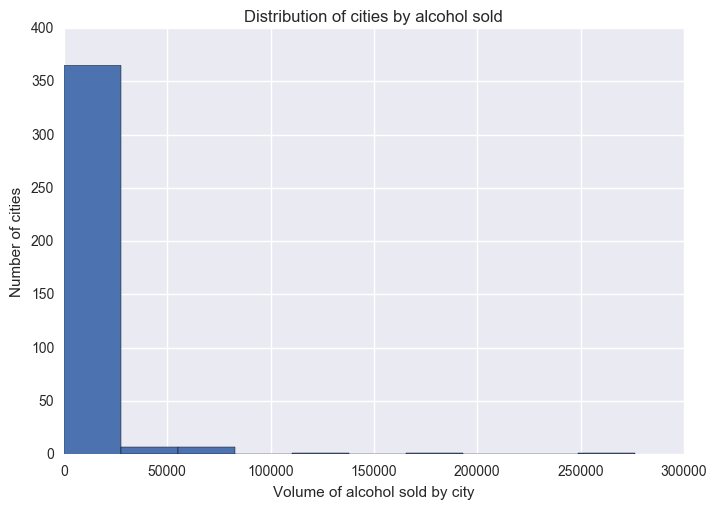

In [34]:
plt.hist(cities['Volume Sold (Liters)'])
plt.title('Distribution of cities by alcohol sold')
plt.xlabel('Volume of alcohol sold by city')
plt.ylabel('Number of cities')
plt.show()

### Which vendors sold the most?

In [35]:
vendors = pd.pivot_table(df, index='Vendor Number', values = ['Volume Sold (Liters)'], aggfunc=np.sum)
vendors.head()

,Volume Sold (Liters)
Vendor Number,
10,290.25
35,93203.61
55,187371.21
65,196693.53
80,1.50


In [36]:
vendors.sort(['Volume Sold (Liters)'], ascending=False, inplace = True)
print vendors['Volume Sold (Liters)'].head(3)
print vendors['Volume Sold (Liters)'].tail(3)

Vendor Number
260    383590.06
434    298401.60
115    224960.61
Name: Volume Sold (Liters), dtype: float64
Vendor Number
376    3.60
446    2.25
80     1.50
Name: Volume Sold (Liters), dtype: float64


/Users/matt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


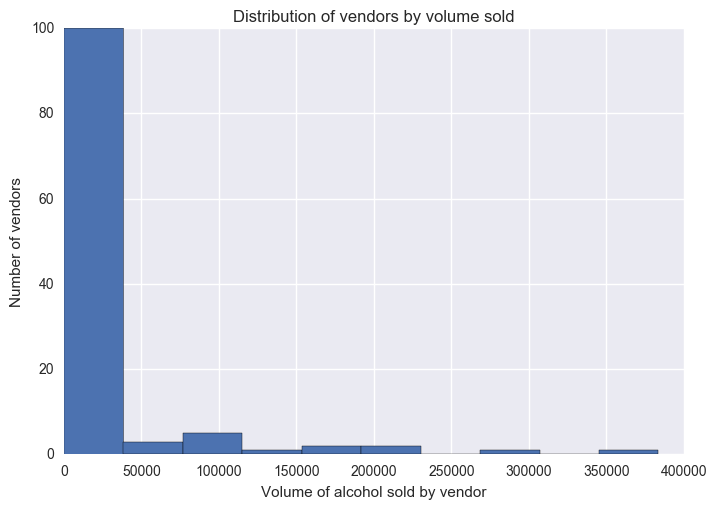

In [37]:
plt.hist(vendors['Volume Sold (Liters)'])
plt.title('Distribution of vendors by volume sold')
plt.xlabel('Volume of alcohol sold by vendor')
plt.ylabel('Number of vendors')
plt.show()

# Conclusions

### Popularity of Drinks

3 types of drinks are consistently at the top of the list of best selling drinks regardless of the type of measure taken:

- Vodka 80 Proof
- Canadian Whiskies
- Spiced Rum

Drink popularity follows a Pareto distribution for all 3 measures, where the vast majority of drinks have very low sales, and the most popular drinks take on extreme values.

### Which cities drink the most?

The top 3 by volume of alcohol sold are:

1. Des Moines
2. Cedar Rapids
3. Davenport

Once again the histogram of number of cities divided into bins of volume of alcohol sold take on a Pareto distribution. The vast majority of cities sold less than 25,000 litres of alcohol in the time period covered by the dataset.

### Which vendors sold the most?

Since vendor numbers are not very informative, they will not be mentioned individually. This also takes on a Pareto distribution, where the vast majority of vendors sold very little, and a small number of vendors sold alcohol at extreme outlier quantities.